In [1]:
from logistic_sgd import *
from mlp import *
import pylab

import theano
import theano.tensor as T
from theano.ifelse import ifelse 

import time, copy, random, os

from IPython.display import display, clear_output

Using gpu device 0: GeForce GTX TITAN Black


In [2]:
def save_params(file_name, classifier):
    with open(file_name, 'wb') as out_file:
        cPickle.dump(classifier.params, out_file)

def set_params(file_name, classifier):
    with open(file_name, 'rb') as in_file:
        new_params = cPickle.load(in_file)
    for current_p, new_p in zip(classifier.params, new_params):
        current_p.set_value(new_p.eval())

def reset_params(file_name, classifier):
    with open(file_name, 'rb') as in_file:
        initial_params = cPickle.load(in_file)
    
    print('Before reset:')
    for p in classifier.params[:2]:
        print(p[0].eval().ravel()[:5])
        
    for initial, current in zip(initial_params, classifier.params):
        current.set_value(initial.eval())
        
    print('After reset')
    for p in classifier.params[:2]:
        print(p[0].eval().ravel()[:5])

def save_valid_error(file_name, valid_error):
    with open(file_name, 'wb') as out_file:
        cPickle.dump(valid_error, out_file)

def get_confidence_for_minibatch(index):
    start = index * batch_size
    end = (index + 1) * batch_size
    return np.mean(np.max(get_p_y_given_x(train_set_x[start:end].eval()), axis=1))

def get_valid_error():
    return np.mean([validate_model(i) for i in xrange(n_valid_batches)])

def should_continue_training(min_valid_error_epoch, epoch_num, diff=100, min_epoch=1000):
    if epoch_num < min_epoch:
        return True
    else:
        return False    
#     return epoch_num - min_valid_error_epoch < diff

**Set the hyperparameters for MLP**

In [3]:
learning_rate = 0.3
L1_reg = 0.00
L2_reg = 1e-4
datapath = os.getenv('DATA_PATH')
dataset = os.path.join(datapath, 'mnist.pkl.gz')
batch_size = 100
n_hidden = 250

dropout_ps = [0.2, 0.5]

**Initialize the data**

In [4]:
datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] / batch_size
n_test_batches = test_set_x.get_value(borrow=True).shape[0] / batch_size

# Allocate symbolic variables for the data
index = T.lscalar()
x = T.matrix('x')
y = T.ivector('y')

... loading data


/home/fujie/anaconda/lib/python2.7/site-packages/theano/tensor/subtensor.py:114: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  stop in [None, length, maxsize] or


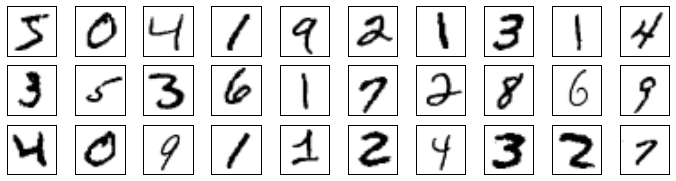

In [5]:
pylab.rcParams['figure.figsize'] = 12, 3
for i, img in enumerate(train_set_x[:30].eval()):
    plt.subplot(3, 10, i+1)
    plt.imshow(img.reshape(28, 28), cmap='Greys')
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.gca().axes.get_yaxis().set_ticks([])

**Train model 1 on $X_0 - X_{25,000}$**

In [8]:
print("Building the model 1 ...")

rng = numpy.random.RandomState(1234)
random.seed(9999)

model_1 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
)

cost_model_1 = model_1.dropout_negative_log_likelihood(y)

validate_model_1 = theano.function(
    inputs=[index],
    outputs=model_1.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

test_model_1 = theano.function(
    inputs=[index],
    outputs=model_1.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

gparams_model_1 = [T.grad(cost_model_1, param) for param in model_1.params]

updates_model_1 = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(model_1.params, gparams_model_1)
]

train_model_1 = theano.function(
    inputs=[index],
    outputs=cost_model_1,
    updates=updates_model_1,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

Building the model 1 ...


|Epoch|Valid error|Min (Epoch)|Sec/epoch
|-:|-:|-:|-:
|  50|0.0331|0.0323 (  48)| 0.8
| 100|0.0272|0.0272 ( 100)| 0.9
| 150|0.0250|0.0245 ( 147)| 0.8
| 200|0.0245|0.0236 ( 197)| 0.8
| 250|0.0229|0.0225 ( 248)| 0.9
| 300|0.0230|0.0221 ( 279)| 0.8
| 350|0.0224|0.0217 ( 339)| 0.8
| 400|0.0222|0.0210 ( 367)| 0.8
| 450|0.0214|0.0210 ( 367)| 0.8
| 500|0.0221|0.0207 ( 493)| 0.8
| 550|0.0210|0.0206 ( 515)| 0.8
| 600|0.0210|0.0204 ( 577)| 0.8
| 650|0.0211|0.0204 ( 577)| 0.8
| 700|0.0213|0.0202 ( 693)| 0.8
| 750|0.0208|0.0201 ( 749)| 0.8
| 800|0.0211|0.0201 ( 749)| 0.8
| 850|0.0210|0.0201 ( 749)| 0.8
| 900|0.0214|0.0201 ( 749)| 0.9
| 950|0.0209|0.0201 ( 749)| 0.8
|1000|0.0207|0.0199 ( 996)| 0.8
Test error: 0.0211


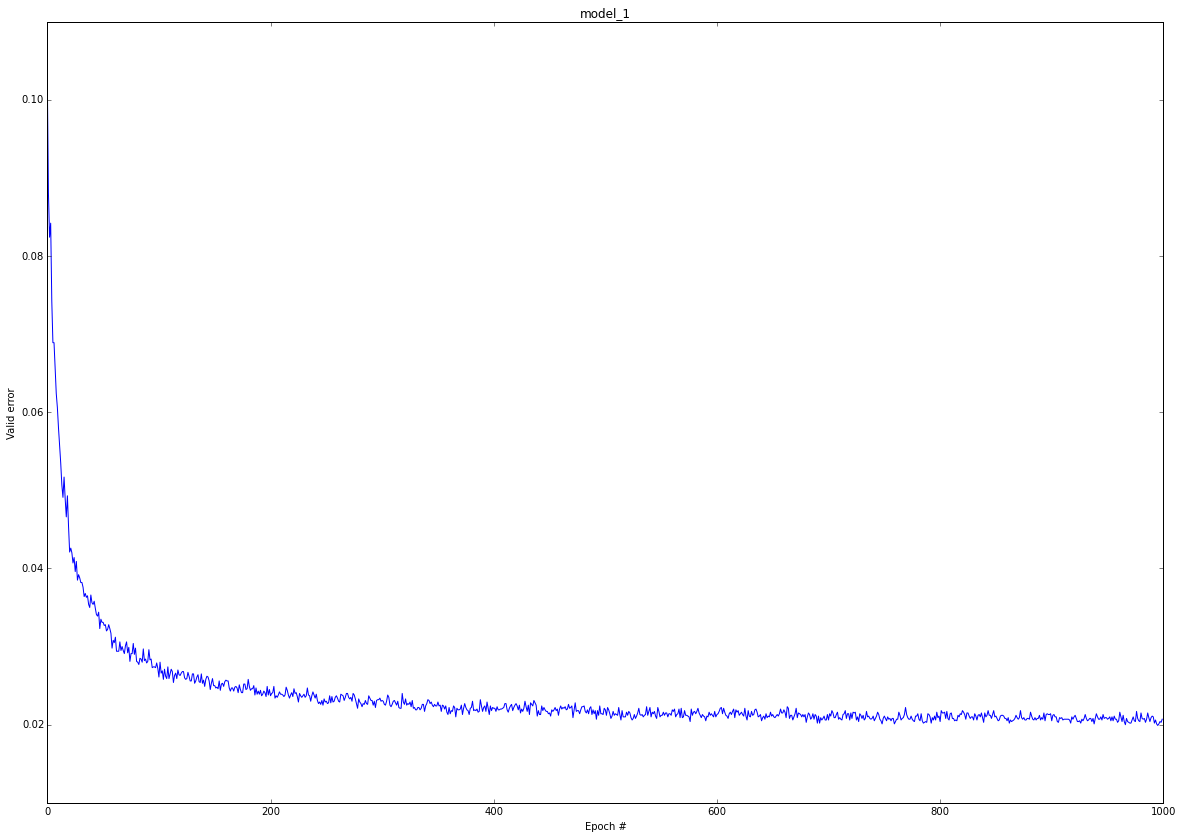

In [9]:
valid_error = []
min_valid_error = np.inf
min_valid_error_epoch = 0
minibatch_indexes = range(int(n_train_batches / 2))
epoch_num = 0

print('|Epoch|Valid error|Min (Epoch)|Sec/epoch')
print('|-:|-:|-:|-:')

while should_continue_training(min_valid_error_epoch, epoch_num):
    epoch_num += 1
    start_time = time.time()
    random.shuffle(minibatch_indexes)
    
    for minibatch_index in minibatch_indexes:
        train_model_1(minibatch_index)
        
    valid_loss = np.mean([validate_model_1(i) for i in xrange(n_valid_batches)])
    valid_error.append(valid_loss)
    
    if valid_loss < min_valid_error:
        min_valid_error = valid_loss
        min_valid_error_epoch = epoch_num
        save_params('model_1_best.pkl', model_1)
    
    if epoch_num % 50 == 0:
        print('|{:>4}|{:.4f}|{:.4f} ({:>4})|{:>4.1f}').format(
            epoch_num, valid_loss, min_valid_error, min_valid_error_epoch,
            time.time() - start_time
        )
    
# Finish training
save_valid_error('model_1_valid_error.pkl', valid_error)

pylab.rcParams['figure.figsize'] = 20, 14
plt.plot(valid_error)
plt.ylabel('Valid error')
plt.xlabel('Epoch #')
plt.title('model_1')

set_params('./model_1_best.pkl', model_1)
test_loss = np.mean([test_model_1(i) for i in xrange(n_test_batches)])
print('Test error: {}'.format(test_loss))

**Train model 2 on $X_{25000} - X_{50000}$**

In [9]:
print("Building the model 2 ...")

rng = numpy.random.RandomState(1234)
random.seed(9999)

model_2 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
)

cost_model_2 = model_2.dropout_negative_log_likelihood(y)

validate_model_2 = theano.function(
    inputs=[index],
    outputs=model_2.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

test_model_2 = theano.function(
    inputs=[index],
    outputs=model_2.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

gparams_model_2 = [T.grad(cost_model_2, param) for param in model_2.params]

updates_model_2 = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(model_2.params, gparams_model_2)
]

train_model_2 = theano.function(
    inputs=[index],
    outputs=cost_model_2,
    updates=updates_model_2,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

Building the model 2 ...


|Epoch|Valid error|Min (Epoch)|Sec/epoch
|-:|-:|-:|-:
|  50|0.0316|0.0312 (  49)| 0.8
| 100|0.0261|0.0252 (  94)| 0.8
| 150|0.0221|0.0220 ( 142)| 0.8
| 200|0.0216|0.0212 ( 177)| 0.8
| 250|0.0213|0.0206 ( 210)| 0.8
| 300|0.0212|0.0196 ( 261)| 0.8
| 350|0.0202|0.0196 ( 261)| 0.8
| 400|0.0196|0.0191 ( 371)| 0.8
| 450|0.0200|0.0189 ( 411)| 0.8
| 500|0.0201|0.0189 ( 411)| 0.8
| 550|0.0202|0.0188 ( 542)| 0.8
| 600|0.0192|0.0188 ( 542)| 0.8
| 650|0.0194|0.0188 ( 542)| 0.8
| 700|0.0198|0.0186 ( 680)| 0.8
| 750|0.0186|0.0183 ( 724)| 0.8
| 800|0.0191|0.0182 ( 759)| 0.8
| 850|0.0193|0.0182 ( 759)| 0.8
| 900|0.0196|0.0181 ( 851)| 0.8
| 950|0.0195|0.0181 ( 851)| 0.8
|1000|0.0190|0.0179 ( 982)| 0.8
Test error: 0.0205


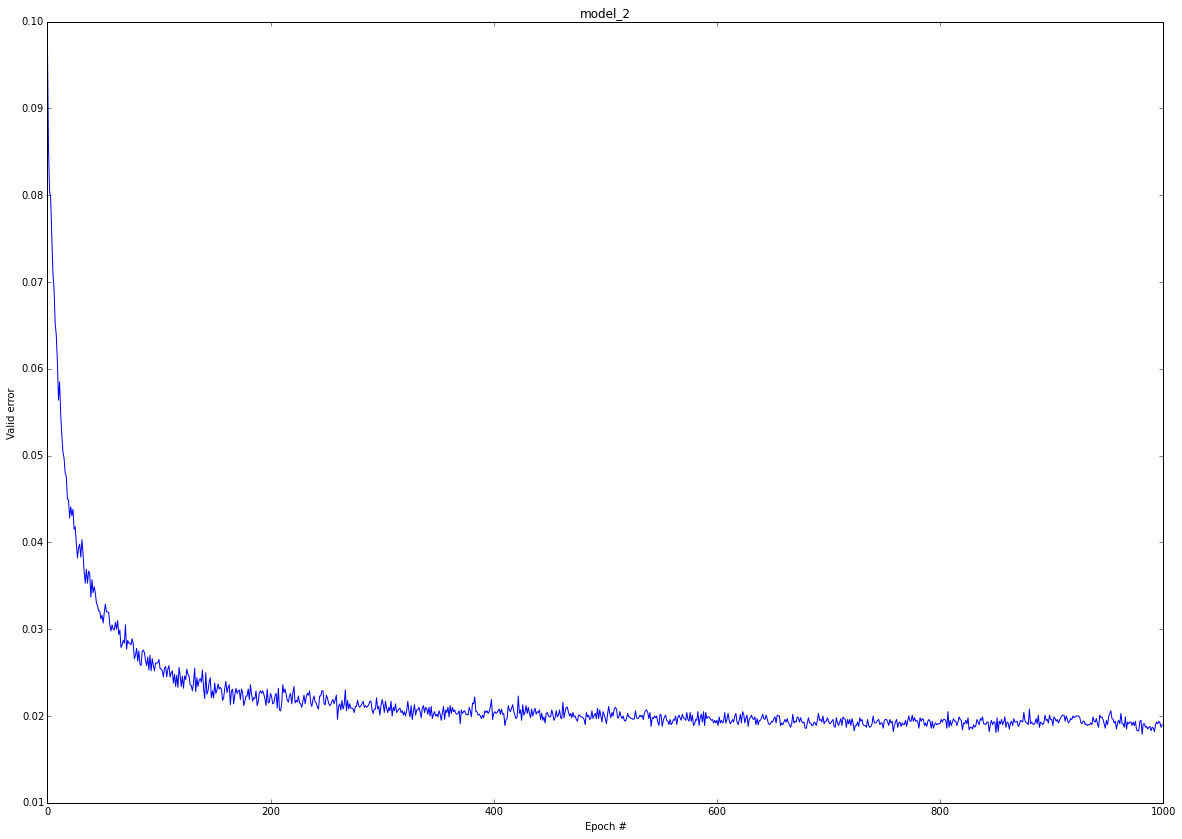

In [11]:
valid_error = []
min_valid_error = np.inf
min_valid_error_epoch = 0
minibatch_indexes = range(int(n_train_batches / 2), n_train_batches)
epoch_num = 0
print('|Epoch|Valid error|Min (Epoch)|Sec/epoch')
print('|-:|-:|-:|-:')

while should_continue_training(min_valid_error_epoch, epoch_num):
    epoch_num += 1
    start_time = time.time()
    random.shuffle(minibatch_indexes)
    
    for minibatch_index in minibatch_indexes:
        train_model_2(minibatch_index)
        
    valid_loss = np.mean([validate_model_2(i) for i in xrange(n_valid_batches)])
    valid_error.append(valid_loss)
    
    if valid_loss < min_valid_error:
        min_valid_error = valid_loss
        min_valid_error_epoch = epoch_num
        save_params('model_2_best.pkl', model_2)
    
    if epoch_num % 50 == 0:
        print('|{:>4}|{:.4f}|{:.4f} ({:>4})|{:>4.1f}').format(
            epoch_num, valid_loss, min_valid_error, min_valid_error_epoch,
            time.time() - start_time
        )
    
# Finish training
save_valid_error('model_2_valid_error.pkl', valid_error)

pylab.rcParams['figure.figsize'] = 20, 14
plt.plot(valid_error)
plt.ylabel('Valid error')
plt.xlabel('Epoch #')
plt.title('model_2')

set_params('./model_2_best.pkl', model_2)
test_loss = np.mean([test_model_2(i) for i in xrange(n_test_batches)])
print('Test error: {}'.format(test_loss))

**Base 1: Ideal setting, use all 50,000 examples**

In [10]:
print("Building the model 1 ...")

rng = numpy.random.RandomState(1234)
random.seed(9999)

model_base_1 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
)

cost_model_base_1 = model_base_1.dropout_negative_log_likelihood(y)

validate_model_base_1 = theano.function(
    inputs=[index],
    outputs=model_base_1.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

test_model_base_1 = theano.function(
    inputs=[index],
    outputs=model_base_1.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

gparams_model_base_1 = [T.grad(cost_model_base_1, param) for param in model_base_1.params]

updates_model_base_1 = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(model_base_1.params, gparams_model_base_1)
]

train_model_base_1 = theano.function(
    inputs=[index],
    outputs=cost_model_base_1,
    updates=updates_model_base_1,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

Building the model 1 ...


|Epoch|Valid error|Min (Epoch)|Sec/epoch
|-:|-:|-:|-:
|  50|0.0257|0.0247 (  44)| 1.6
| 100|0.0225|0.0215 (  74)| 1.6
| 150|0.0216|0.0190 ( 149)| 1.6
| 200|0.0191|0.0184 ( 185)| 1.6
| 250|0.0189|0.0176 ( 223)| 1.6
| 300|0.0188|0.0174 ( 283)| 1.6
| 350|0.0174|0.0173 ( 341)| 1.6
| 400|0.0176|0.0166 ( 397)| 1.6
| 450|0.0164|0.0164 ( 439)| 1.6
| 500|0.0173|0.0161 ( 472)| 1.7
| 550|0.0175|0.0161 ( 472)| 1.6
| 600|0.0163|0.0161 ( 588)| 1.6
| 650|0.0179|0.0159 ( 625)| 1.6
| 700|0.0170|0.0159 ( 625)| 1.6
| 750|0.0166|0.0158 ( 720)| 1.6
| 800|0.0162|0.0158 ( 720)| 1.6
| 850|0.0160|0.0157 ( 816)| 1.6
| 900|0.0166|0.0157 ( 816)| 1.6
| 950|0.0170|0.0157 ( 816)| 1.6
|1000|0.0165|0.0157 ( 816)| 1.6
Test error: 0.0176


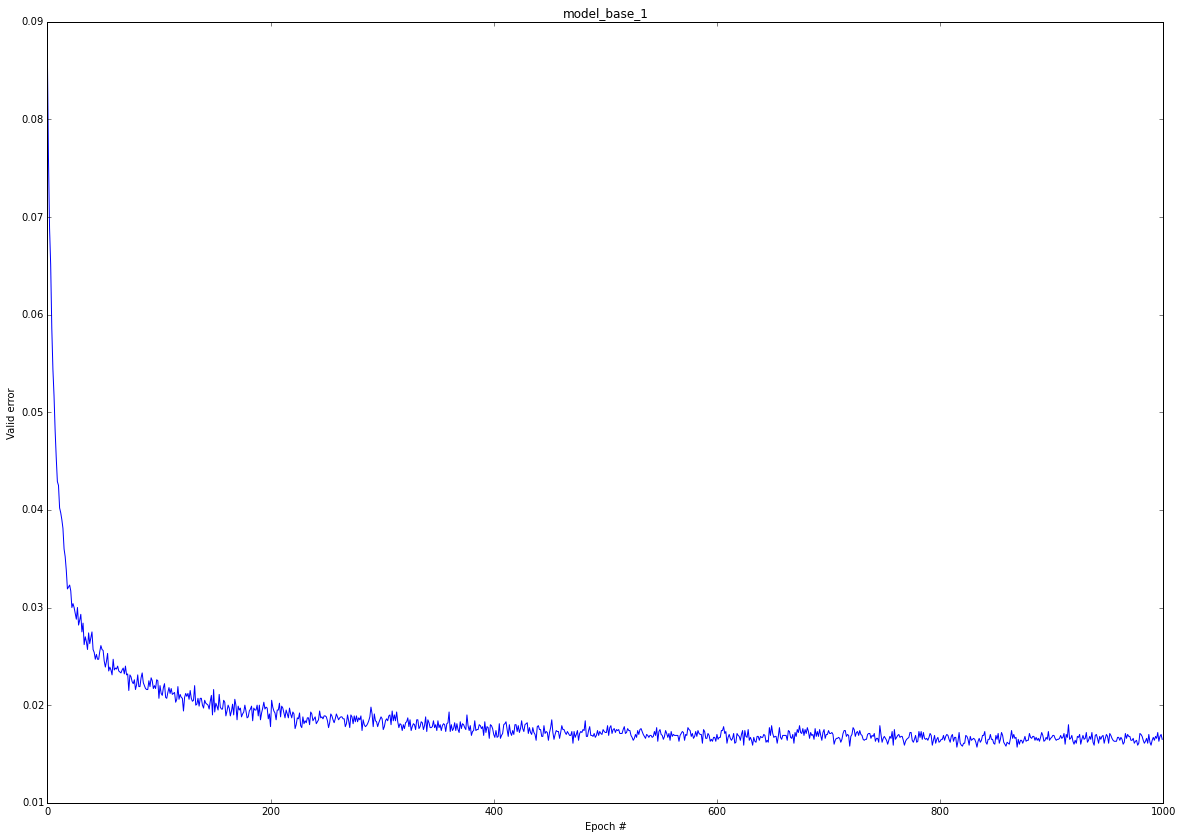

In [13]:
valid_error = []
min_valid_error = np.inf
min_valid_error_epoch = 0
minibatch_indexes = range(n_train_batches)
epoch_num = 0
print('|Epoch|Valid error|Min (Epoch)|Sec/epoch')
print('|-:|-:|-:|-:')

while should_continue_training(min_valid_error_epoch, epoch_num):
    epoch_num += 1
    start_time = time.time()
    random.shuffle(minibatch_indexes)
    
    for minibatch_index in minibatch_indexes:
        train_model_base_1(minibatch_index)
        
    valid_loss = np.mean([validate_model_base_1(i) for i in xrange(n_valid_batches)])
    valid_error.append(valid_loss)
    
    if valid_loss < min_valid_error:
        min_valid_error = valid_loss
        min_valid_error_epoch = epoch_num
        save_params('model_base_1_best.pkl', model_base_1)
    
    if epoch_num % 50 == 0:
        print('|{:>4}|{:.4f}|{:.4f} ({:>4})|{:>4.1f}').format(
            epoch_num, valid_loss, min_valid_error, min_valid_error_epoch,
            time.time() - start_time
        )
    
# Finish training
save_valid_error('model_base_1_valid_error.pkl', valid_error)

pylab.rcParams['figure.figsize'] = 20, 14
plt.plot(valid_error)
plt.ylabel('Valid error')
plt.xlabel('Epoch #')
plt.title('model_base_1')

set_params('./model_base_1_best.pkl', model_base_1)
test_loss = np.mean([test_model_base_1(i) for i in xrange(n_test_batches)])
print('Test error: {}'.format(test_loss))

**Base 2: Train a new model, init with param of model_1_best**

In [11]:
print("Building the model 1 ...")

rng = numpy.random.RandomState(1234)
random.seed(9999)

model_base_2 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
)
set_params('model_1_best.pkl', model_base_2)

cost_model_base_2 = model_base_2.dropout_negative_log_likelihood(y)

validate_model_base_2 = theano.function(
    inputs=[index],
    outputs=model_base_2.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

test_model_base_2 = theano.function(
    inputs=[index],
    outputs=model_base_2.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

gparams_model_base_2 = [T.grad(cost_model_base_2, param) for param in model_base_2.params]

updates_model_base_2 = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(model_base_2.params, gparams_model_base_2)
]

train_model_base_2 = theano.function(
    inputs=[index],
    outputs=cost_model_base_2,
    updates=updates_model_base_2,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

Building the model 1 ...


|Epoch|Valid error|Min (Epoch)|Sec/epoch
|-:|-:|-:|-:
|  50|0.0191|0.0185 (  19)| 0.8
| 100|0.0189|0.0181 (  95)| 0.8
| 150|0.0188|0.0179 ( 139)| 0.8
| 200|0.0180|0.0175 ( 196)| 0.9
| 250|0.0188|0.0175 ( 196)| 0.8
| 300|0.0180|0.0173 ( 293)| 0.8
| 350|0.0179|0.0173 ( 293)| 0.8
| 400|0.0183|0.0173 ( 293)| 0.8
| 450|0.0182|0.0171 ( 441)| 0.8
| 500|0.0182|0.0169 ( 479)| 0.9
| 550|0.0178|0.0169 ( 479)| 0.8
| 600|0.0177|0.0167 ( 589)| 0.8
| 650|0.0182|0.0167 ( 589)| 0.8
| 700|0.0173|0.0167 ( 589)| 0.8
| 750|0.0174|0.0167 ( 589)| 0.8
| 800|0.0172|0.0167 ( 589)| 0.8
| 850|0.0174|0.0166 ( 835)| 0.8
| 900|0.0168|0.0166 ( 835)| 0.8
| 950|0.0177|0.0166 ( 835)| 0.8
|1000|0.0181|0.0165 ( 967)| 0.8
Test error: 0.0197


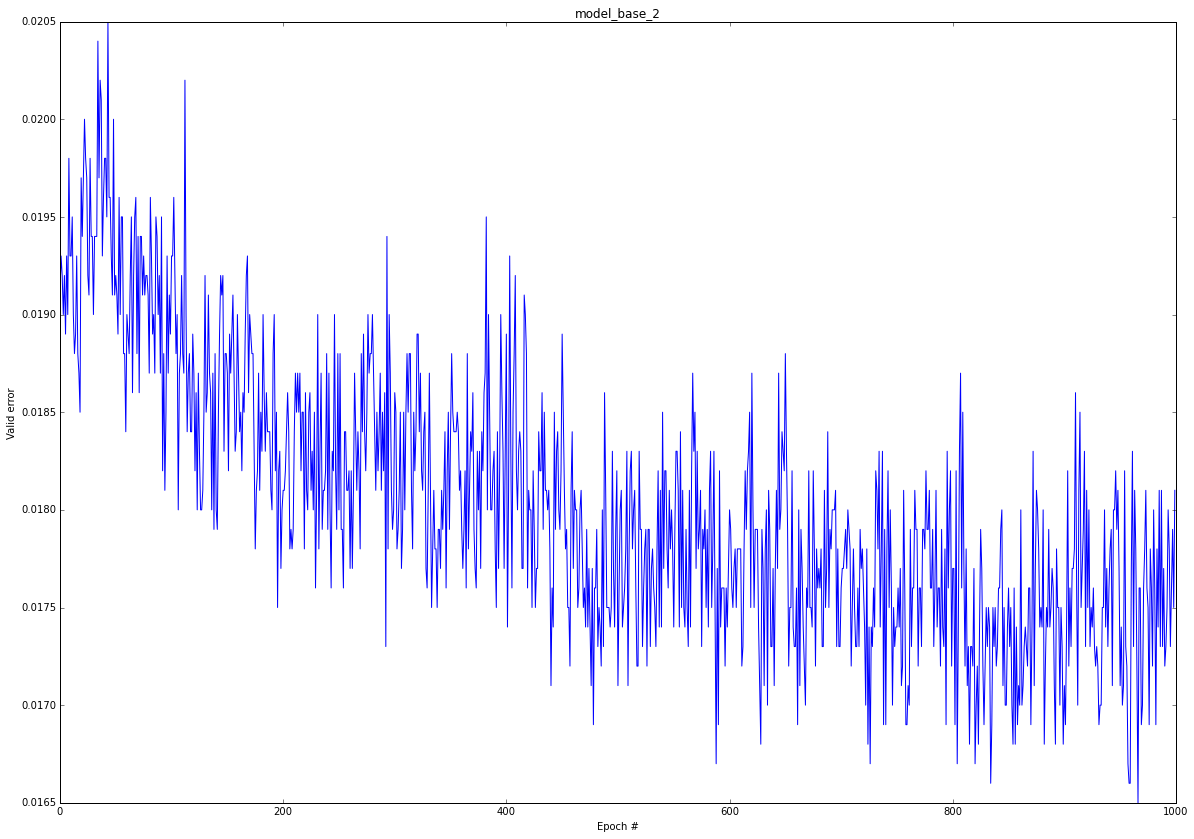

In [12]:
valid_error = []
min_valid_error = np.inf
min_valid_error_epoch = 0
minibatch_indexes = range(int(n_train_batches * 0.50), n_train_batches)
epoch_num = 0
print('|Epoch|Valid error|Min (Epoch)|Sec/epoch')
print('|-:|-:|-:|-:')

while should_continue_training(min_valid_error_epoch, epoch_num):
    epoch_num += 1
    start_time = time.time()
    random.shuffle(minibatch_indexes)
    
    for minibatch_index in minibatch_indexes:
        train_model_base_2(minibatch_index)
        
    valid_loss = np.mean([validate_model_base_2(i) for i in xrange(n_valid_batches)])
    valid_error.append(valid_loss)
    
    if valid_loss < min_valid_error:
        min_valid_error = valid_loss
        min_valid_error_epoch = epoch_num
        save_params('model_base_2_best.pkl', model_base_2)
    
    if epoch_num % 50 == 0:
        print('|{:>4}|{:.4f}|{:.4f} ({:>4})|{:>4.1f}').format(
            epoch_num, valid_loss, min_valid_error, min_valid_error_epoch,
            time.time() - start_time
        )
    
# Finish training
save_valid_error('model_base_2_valid_error.pkl', valid_error)

pylab.rcParams['figure.figsize'] = 20, 14
plt.plot(valid_error)
plt.ylabel('Valid error')
plt.xlabel('Epoch #')
plt.title('model_base_2')

set_params('./model_base_2_best.pkl', model_base_2)
test_loss = np.mean([test_model_base_2(i) for i in xrange(n_test_batches)])
print('Test error: {}'.format(test_loss))

**Base 3: Train using half of partition 1, half of partition 2**

In [14]:
print("Building model_base_3 ...")

rng = numpy.random.RandomState(1234)
random.seed(9999)

model_base_3 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
)

cost_model_base_3 = model_base_3.dropout_negative_log_likelihood(y)

validate_model_base_3 = theano.function(
    inputs=[index],
    outputs=model_base_3.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

test_model_base_3 = theano.function(
    inputs=[index],
    outputs=model_base_3.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

gparams_model_base_3 = [T.grad(cost_model_base_3, param) for param in model_base_3.params]

updates_model_base_3 = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(model_base_3.params, gparams_model_base_3)
]

train_model_base_3 = theano.function(
    inputs=[index],
    outputs=cost_model_base_3,
    updates=updates_model_base_3,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

Building model_base_3 ...


|Epoch|Valid error|Min (Epoch)|Sec/epoch
|-:|-:|-:|-:
|  50|0.0246|0.0246 (  50)| 2.1
| 100|0.0236|0.0230 (  82)| 2.1
| 150|0.0229|0.0224 ( 126)| 0.3
| 200|0.0225|0.0218 ( 166)| 2.0
| 250|0.0228|0.0213 ( 246)| 2.1
| 300|0.0219|0.0211 ( 297)| 2.0
| 350|0.0216|0.0209 ( 327)| 2.0
| 400|0.0225|0.0209 ( 327)| 2.1
| 450|0.0222|0.0209 ( 327)| 1.9
| 500|0.0227|0.0205 ( 498)| 0.3
| 550|0.0221|0.0205 ( 498)| 0.3
| 600|0.0217|0.0205 ( 498)| 2.0
| 650|0.0215|0.0205 ( 498)| 2.2
| 700|0.0217|0.0205 ( 498)| 2.2
| 750|0.0211|0.0205 ( 498)| 0.3
| 800|0.0218|0.0205 ( 498)| 2.0
| 850|0.0218|0.0205 ( 498)| 2.0
| 900|0.0225|0.0205 ( 498)| 0.3
| 950|0.0213|0.0205 ( 498)| 0.3
|1000|0.0213|0.0205 ( 498)| 0.3
Test error: 0.0223


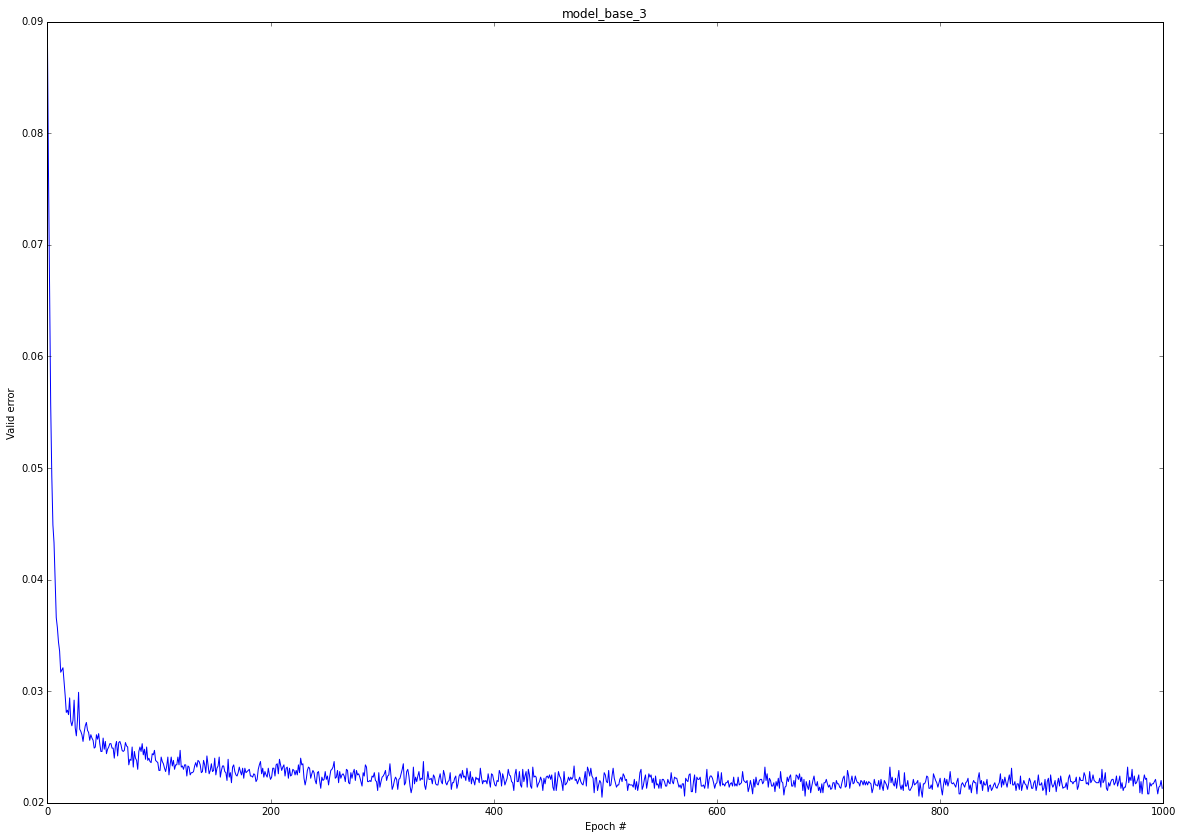

In [15]:
valid_error = []
min_valid_error = np.inf
min_valid_error_epoch = 0
minibatch_indexes = range(int(n_train_batches * 0.25), int(n_train_batches * 0.75))
epoch_num = 0
print('|Epoch|Valid error|Min (Epoch)|Sec/epoch')
print('|-:|-:|-:|-:')

while should_continue_training(min_valid_error_epoch, epoch_num):
    epoch_num += 1
    start_time = time.time()
    random.shuffle(minibatch_indexes)
    
    for minibatch_index in minibatch_indexes:
        train_model_base_3(minibatch_index)
        
    valid_loss = np.mean([validate_model_base_3(i) for i in xrange(n_valid_batches)])
    valid_error.append(valid_loss)
    
    if valid_loss < min_valid_error:
        min_valid_error = valid_loss
        min_valid_error_epoch = epoch_num
        save_params('model_base_3_best.pkl', model_base_3)
    
    if epoch_num % 50 == 0:
        print('|{:>4}|{:.4f}|{:.4f} ({:>4})|{:>4.1f}').format(
            epoch_num, valid_loss, min_valid_error, min_valid_error_epoch,
            time.time() - start_time
        )
    
# Finish training
save_valid_error('model_base_3_valid_error.pkl', valid_error)

pylab.rcParams['figure.figsize'] = 20, 14
plt.plot(valid_error)
plt.ylabel('Valid error')
plt.xlabel('Epoch #')
plt.title('model_base_3')

set_params('./model_base_3_best.pkl', model_base_3)
test_loss = np.mean([test_model_base_3(i) for i in xrange(n_test_batches)])
print('Test error: {}'.format(test_loss))

**Base 4: Initialize with average of 2 models, train w/o KD**

In [10]:
def set_avg_params(path_0, path_1, model):
    with open(path_0, 'rb') as in_file:
        params_0 = cPickle.load(in_file)
        
    with open(path_1, 'rb') as in_file:
        params_1 = cPickle.load(in_file)
        
    avgs = []
    for p0, p1 in zip(params_0, params_1):
        avgs.append( (p0.get_value() + p1.get_value())  / 2.0  )
    
    for current_p, new_p in zip(model.params, avgs):
        current_p.set_value(new_p)

In [14]:
print("Building model_base_4...")

rng = numpy.random.RandomState(1234)
random.seed(9999)

model_1 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
    #temperature=temperature,
)

model_2 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
    #temperature=temperature,
)

set_params('./model_1_best.pkl', model_1)
set_params('./model_2_best.pkl', model_2)

model_base_4 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    dropout_ps=dropout_ps
    # temperature=temperature,
)
set_avg_params('model_1_best.pkl', 'model_2_best.pkl', model_base_4)

cost_model_base_4 = model_base_4.dropout_negative_log_likelihood(y)

validate_model_base_4 = theano.function(
    inputs=[index],
    outputs=model_base_4.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

test_model_base_4 = theano.function(
    inputs=[index],
    outputs=model_base_4.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

gparams_model_base_4 = [T.grad(cost_model_base_4, param) for param in model_base_4.params]

updates_model_base_4 = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(model_base_4.params, gparams_model_base_4)
]

train_model_base_4 = theano.function(
    inputs=[index],
    outputs=cost_model_base_4,
    updates=updates_model_base_4,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

Building model_base_4...


|Epoch|Valid error|Min (Epoch)|Sec/epoch
|-:|-:|-:|-:
|  50|0.0192|0.0187 (  30)| 0.3
| 100|0.0203|0.0187 (  30)| 0.3
| 150|0.0204|0.0187 (  30)| 0.3
| 200|0.0210|0.0187 (  30)| 0.3
| 250|0.0212|0.0187 (  30)| 0.3
| 300|0.0207|0.0187 (  30)| 0.3
| 350|0.0209|0.0187 (  30)| 0.3
| 400|0.0214|0.0187 (  30)| 0.3
| 450|0.0209|0.0187 (  30)| 0.3
| 500|0.0213|0.0187 (  30)| 0.3
| 550|0.0197|0.0187 (  30)| 0.3
| 600|0.0206|0.0187 (  30)| 0.3
| 650|0.0216|0.0187 (  30)| 0.3
| 700|0.0216|0.0187 (  30)| 0.3
| 750|0.0206|0.0187 (  30)| 0.3
| 800|0.0217|0.0187 (  30)| 0.3
| 850|0.0209|0.0187 (  30)| 0.3
| 900|0.0216|0.0187 (  30)| 0.3
| 950|0.0202|0.0187 (  30)| 0.3
|1000|0.0199|0.0187 (  30)| 0.3
Test error: 0.0203


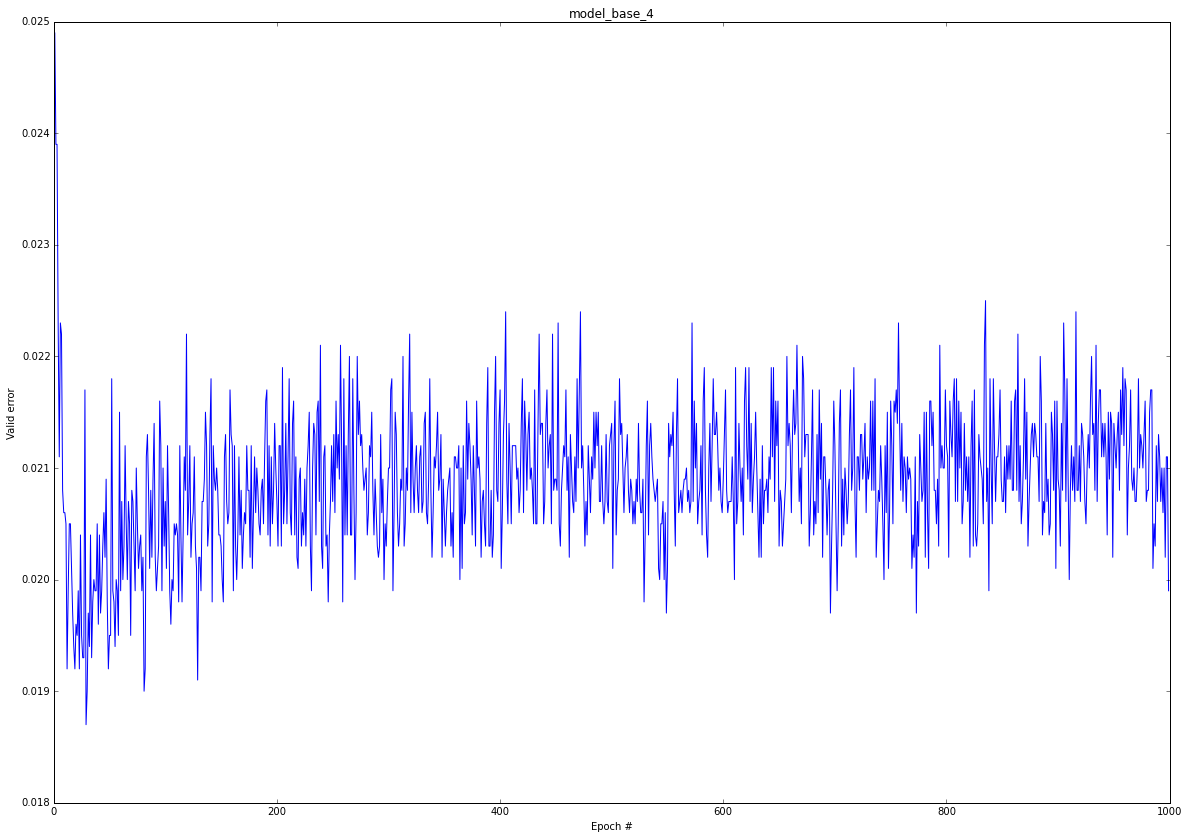

In [15]:
valid_error = []
min_valid_error = np.inf
min_valid_error_epoch = 0
minibatch_indexes = range(int(n_train_batches * 0.25), int(n_train_batches * 0.75))
epoch_num = 0
print('|Epoch|Valid error|Min (Epoch)|Sec/epoch')
print('|-:|-:|-:|-:')

while should_continue_training(min_valid_error_epoch, epoch_num):
    epoch_num += 1
    start_time = time.time()
    random.shuffle(minibatch_indexes)
    
    for minibatch_index in minibatch_indexes:
        train_model_base_4(minibatch_index)
        
    valid_loss = np.mean([validate_model_base_4(i) for i in xrange(n_valid_batches)])
    valid_error.append(valid_loss)
    
    if valid_loss < min_valid_error:
        min_valid_error = valid_loss
        min_valid_error_epoch = epoch_num
        save_params('model_base_4_best.pkl', model_base_4)
    
    if epoch_num % 50 == 0:
        print('|{:>4}|{:.4f}|{:.4f} ({:>4})|{:>4.1f}').format(
            epoch_num, valid_loss, min_valid_error, min_valid_error_epoch,
            time.time() - start_time
        )
    
# Finish training
save_valid_error('model_base_4_valid_error.pkl', valid_error)

pylab.rcParams['figure.figsize'] = 20, 14
plt.plot(valid_error)
plt.ylabel('Valid error')
plt.xlabel('Epoch #')
plt.title('model_base_4')

set_params('./model_base_4_best.pkl', model_base_4)
test_loss = np.mean([test_model_base_4(i) for i in xrange(n_test_batches)])
print('Test error: {}'.format(test_loss))

**Combine 2 models $\rightarrow$ model_merged**

$$ L_{KD}(W_S) = H(y_true, P_S) + \lambda \cdot( H(P_{T_i}^\tau , P_S^\tau) )$$

In [6]:
temperature = 15.52074623
lambda_teacher = 0.27143043

In [23]:
print("Building model_merged...")

rng = numpy.random.RandomState(1234)
random.seed(9999)

dropout_ps=[0.2, 0.5]

model_1 = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    temperature=temperature,
    dropout_ps=dropout_ps
)
set_params('./model_1_best.pkl', model_1)

model_merged = MLP(
    rng=rng,
    input=x,
    n_in=28 * 28,
    n_hidden=n_hidden,
    n_out=10,
    temperature=temperature,
    dropout_ps=dropout_ps
)
set_params('model_1_best.pkl', model_merged)

cost_wrt_target = (
    -T.log(model_merged.p_y_given_x)[T.arange(y.shape[0]), y] 
)

cost_wrt_teacher = (
    T.sum(-T.log(model_merged.p_y_given_x_relaxed) * model_1.dropout_p_y_given_x_relaxed,
          axis=1)
)

cost_model_merged = T.mean(
    (1 - lambda_teacher) * cost_wrt_target + lambda_teacher * cost_wrt_teacher
)

gparams_model_merged = (
    [T.grad(cost_model_merged, param) for param in model_merged.params]
)

validate_model_merged = theano.function(
    inputs=[index],
    outputs=model_merged.errors(y),
    givens={
        x: valid_set_x[index * batch_size:(index + 1) * batch_size],
        y: valid_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

test_model_merged = theano.function(
    inputs=[index],
    outputs=model_merged.errors(y),
    givens={
        x: test_set_x[index * batch_size:(index + 1) * batch_size],
        y: test_set_y[index * batch_size:(index + 1) * batch_size]
    }
)

updates_model_merged = [
    (param, param - learning_rate * gparam)
    for param, gparam in zip(model_merged.params, gparams_model_merged)
]

train_model_merged = theano.function(
    inputs=[index],
    outputs=cost_model_merged,
    updates=updates_model_merged,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

Building model_merged...


|Epoch|Valid error|Min (Epoch)|Sec/epoch
|-:|-:|-:|-:
|  50|0.0167|0.0165 (  49)| 1.1
| 100|0.0164|0.0161 (  71)| 1.1
| 150|0.0161|0.0159 ( 143)| 1.1
| 200|0.0163|0.0159 ( 143)| 1.1
| 250|0.0162|0.0159 ( 143)| 1.1
| 300|0.0166|0.0159 ( 143)| 1.1
| 350|0.0167|0.0159 ( 143)| 1.1
| 400|0.0167|0.0159 ( 143)| 1.1
| 450|0.0165|0.0159 ( 143)| 1.1
| 500|0.0163|0.0159 ( 143)| 1.1
| 550|0.0161|0.0159 ( 143)| 1.1
| 600|0.0162|0.0159 ( 143)| 1.1
| 650|0.0156|0.0156 ( 650)| 1.1
| 700|0.0156|0.0155 ( 678)| 1.1
| 750|0.0156|0.0155 ( 678)| 1.1
| 800|0.0155|0.0155 ( 678)| 1.1
| 850|0.0155|0.0155 ( 678)| 1.1
| 900|0.0155|0.0154 ( 886)| 1.1
| 950|0.0154|0.0154 ( 886)| 1.1
|1000|0.0154|0.0154 ( 886)| 1.1
Test error: 0.0178


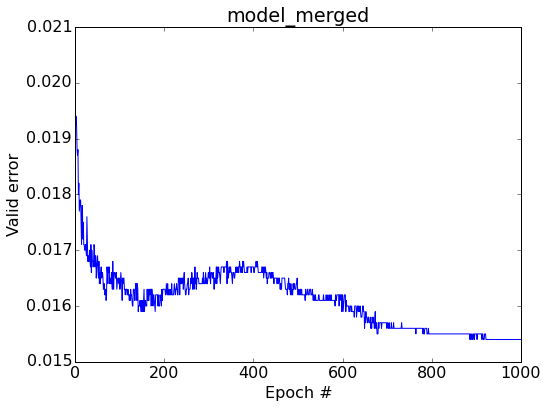

In [24]:
valid_error = []
min_valid_error = np.inf
min_valid_error_epoch = 0
minibatch_indexes = range(int(n_train_batches * 0.50), int(n_train_batches * 1.00))
epoch_num = 0
print('|Epoch|Valid error|Min (Epoch)|Sec/epoch')
print('|-:|-:|-:|-:')

while should_continue_training(min_valid_error_epoch, epoch_num):
    epoch_num += 1
    start_time = time.time()
    random.shuffle(minibatch_indexes)
    
    for minibatch_index in minibatch_indexes:
        train_model_merged(minibatch_index)
        
    valid_loss = np.mean([validate_model_merged(i) for i in xrange(n_valid_batches)])
    valid_error.append(valid_loss)
    
    if valid_loss < min_valid_error:
        min_valid_error = valid_loss
        min_valid_error_epoch = epoch_num
        save_params('model_merged_best.pkl', model_merged)
    
    if epoch_num % 50 == 0:
        print('|{:>4}|{:.4f}|{:.4f} ({:>4})|{:>4.1f}').format(
            epoch_num, valid_loss, min_valid_error, min_valid_error_epoch,
            time.time() - start_time
        )
    
# Finish training
save_valid_error('model_merged_valid_error.pkl', valid_error)

pylab.rcParams['figure.figsize'] = 8, 6
plt.plot(valid_error)
plt.ylabel('Valid error')
plt.xlabel('Epoch #')
plt.title('model_merged')

set_params('./model_merged_best.pkl', model_merged)
test_loss = np.mean([test_model_merged(i) for i in xrange(n_test_batches)])
print('Test error: {}'.format(test_loss))

|  50|0.0167|0.0166 (  35)| 1.0
| 100|0.0165|0.0161 (  68)| 1.0
| 150|0.0159|0.0159 ( 150)| 1.0
| 200|0.0162|0.0159 ( 150)| 1.0
| 250|0.0163|0.0159 ( 150)| 1.0
| 300|0.0166|0.0159 ( 150)| 1.0
| 350|0.0169|0.0159 ( 150)| 1.0
| 400|0.0168|0.0159 ( 150)| 1.0
| 450|0.0165|0.0159 ( 150)| 1.0
| 500|0.0164|0.0159 ( 150)| 1.0
| 550|0.0162|0.0159 ( 150)| 1.0
| 600|0.0160|0.0159 ( 150)| 1.0
| 650|0.0159|0.0158 ( 648)| 1.0
| 700|0.0157|0.0156 ( 666)| 1.0
| 750|0.0156|0.0156 ( 666)| 1.0
| 800|0.0156|0.0155 ( 780)| 1.0
| 850|0.0154|0.0154 ( 804)| 1.0
| 900|0.0154|0.0154 ( 804)| 1.0
| 950|0.0154|0.0154 ( 804)| 1.0
|1000|0.0154|0.0153 ( 979)| 1.0
Test error: 0.0178

In [12]:
def plot(file_paths):
    for file_path in file_paths:
        with open(file_path) as in_file:
            valid_error = cPickle.load(in_file)
            plt.plot(valid_error, label=os.path.basename(file_path))
    plt.ylabel('valid error')
    plt.xlabel('epoch')
    plt.legend()

In [15]:
!pwd

/home/fujie/Git/incremental-kd/mnist/merge_2


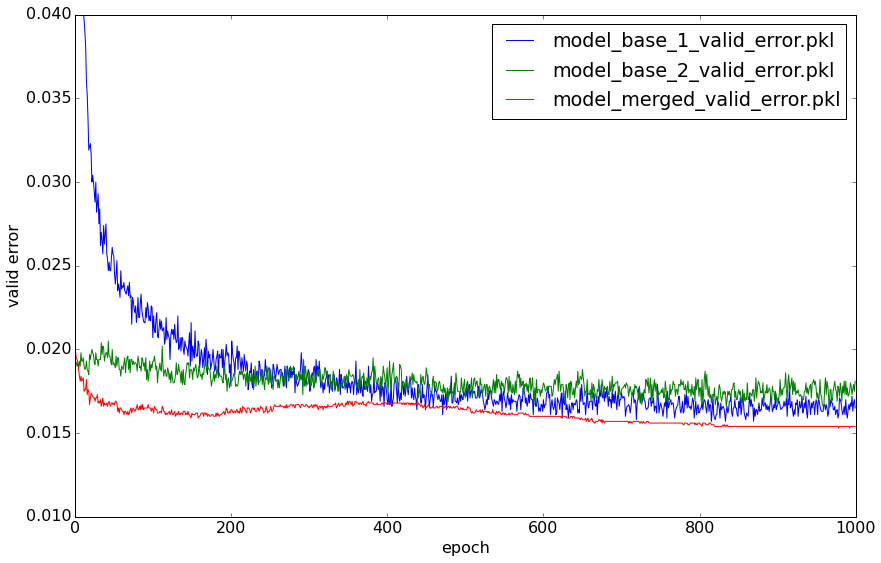

In [18]:
valid_error_files = ['model_base_1_valid_error.pkl', 
                     'model_base_2_valid_error.pkl', 
                     'model_merged_valid_error.pkl']
# valid_error_files = [
# 'no_split.pkl', 'split.pkl', 'average.pkl', 'step.pkl', 'step_kd.pkl'
# ]
pylab.rcParams['figure.figsize'] = 14, 9
pylab.rcParams['font.size'] = 16
plt.ylim(0.010, 0.040)
plot(valid_error_files)